# Decoding Shor's Code

In this experiment, we decode Shor's nine-qubit quantum error correcting code which protects a single qubit from all types of errors. Here, we demonstrate error-based correction, which means that the decoder takes a Pauli error as input and outputs the most likely logical operator. After one run of the algorithm we will end up with a probability distribution over I, X, Z, Y Pauli operators which are to be applied to the logical qubit encoded. In this experiment, we do not truncate thus perform exact maximum likelihood decoding.

In [35]:
import numpy as np
import qecstruct as qc
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from tqdm import tqdm

from mdopt.mps.utils import marginalise, create_custom_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)
from examples.decoding.decoding import (
    css_code_checks,
    css_code_logicals,
    css_code_logicals_sites,
    css_code_constraint_sites,
)
from examples.decoding.decoding import (
    apply_constraints,
    apply_bitflip_bias,
)
from examples.decoding.decoding import (
    pauli_to_mps,
    decode_css,
)

import numpy as np
from tqdm import tqdm
import qecstruct as qc
from scipy.stats import sem
import qecsim.paulitools as pt

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter

from mdopt.mps.utils import marginalise, create_custom_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)
from examples.decoding.decoding import (
    apply_constraints,
    apply_bitflip_bias,
    css_code_stabilisers,
    multiply_pauli_strings,
)
from examples.decoding.decoding import (
    decode_css,
    pauli_to_mps,
    css_code_checks,
    css_code_logicals,
    css_code_stabilisers,
    css_code_logicals_sites,
    css_code_constraint_sites,
    generate_pauli_error_string,
)

Let us first import the code from `qecstruct` and take a look at it.

In [36]:
LATTICE_SIZE = 3
rep_code = qc.repetition_code(LATTICE_SIZE)
code = qc.hypergraph_product(rep_code, rep_code)
print(code)
print("The X logical: ", code.x_logicals_binary())
print("The Z logical: ", code.z_logicals_binary())

X stabilizers:
[0, 1, 9]
[1, 2, 10]
[3, 4, 9, 11]
[4, 5, 10, 12]
[6, 7, 11]
[7, 8, 12]
Z stabilizers:
[0, 3, 9]
[1, 4, 9, 10]
[2, 5, 10]
[3, 6, 11]
[4, 7, 11, 12]
[5, 8, 12]

The X logical:  [2, 5, 8]

The Z logical:  [0, 1, 2]



This quantum error correcting code is defined on $2 * L * (L-1) + 1 = 13$ (where $L$ is the lattice size and an extra qubit handles the boundary conditions) physical qubits and has $2$ logical operators because it encodes $1$ logical qubit. This means we will need $13*2 + 2 = 28$ sites in our MPS.

In [37]:
num_logicals = code.num_x_logicals() + code.num_z_logicals()
num_sites = 2 * len(code) + num_logicals

assert num_sites == 28
assert num_logicals == 2

Now, let us define the initial state. First of all we will check that no error implies no correction. This means starting from the all-zeros state followed by decoding will return all-zeros state for the logical operators (the final logical operator will thus be identity operator). Thus, we start from the all-zero state for the error and the $|+\rangle$ state for the logicals.

In [38]:
error_state = "0" * (num_sites - num_logicals)
logicals_state = "+" * num_logicals
state_string = logicals_state + error_state
error_mps = create_custom_product_state(string=state_string)

Here, we get the sites where the checks will be applied. We will need to construct MPOs using this data.

In [39]:
checks_x, checks_z = css_code_checks(code)
print("X checks:")
for check in checks_x:
    print(check)
print("Z checks:")
for check in checks_z:
    print(check)

X checks:
[2, 4, 20]
[4, 6, 22]
[8, 10, 20, 24]
[10, 12, 22, 26]
[14, 16, 24]
[16, 18, 26]
Z checks:
[3, 9, 21]
[5, 11, 21, 23]
[7, 13, 23]
[9, 15, 25]
[11, 17, 25, 27]
[13, 19, 27]


These lists mention only the sites where we will apply the XOR constraints. However, the MPOs will also consist of other tensors, such as SWAPs (tensors' legs crossings) and boundary XOR constraints. In what follows we define the list of these auxiliary tensors and the corresponding sites where they reside.

In [40]:
constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

In [41]:
constraints_sites = css_code_constraint_sites(code)
print("Full X-check lists of sites:")
for string in constraints_sites[0]:
    print(string)
print("Full Z-check lists of sites:")
for string in constraints_sites[1]:
    print(string)

Full X-check lists of sites:
[[2], [4], [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20]]
[[4], [6], [5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [22]]
[[8], [10, 20], [9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23], [24]]
[[10], [12, 22], [11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25], [26]]
[[14], [16], [15, 17, 18, 19, 20, 21, 22, 23], [24]]
[[16], [18], [17, 19, 20, 21, 22, 23, 24, 25], [26]]
Full Z-check lists of sites:
[[3], [9], [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21]]
[[5], [11, 21], [6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22], [23]]
[[7], [13], [8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22], [23]]
[[9], [15], [10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24], [25]]
[[11], [17, 25], [12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26], [27]]
[[13], [19], [14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26], [27]]


Let us now again take a look at the logical operators.

In [42]:
print(code.x_logicals_binary())
print(code.z_logicals_binary())

[2, 5, 8]

[0, 1, 2]



We need to again translate them to our MPO language by changing the indices since we add the logical sites at the beginning of the MPS.

In [43]:
print(css_code_logicals(code)[0])
print(css_code_logicals(code)[1])

[6, 12, 18]
[3, 5, 7]


Now goes the same operation of adding sites where auxiliary tensors should be placed.

In [44]:
logicals_sites = css_code_logicals_sites(code)
print(css_code_logicals_sites(code)[0])
print(css_code_logicals_sites(code)[1])

[[0], [6, 12], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17], [18]]
[[1], [3, 5], [2, 4, 6], [7]]


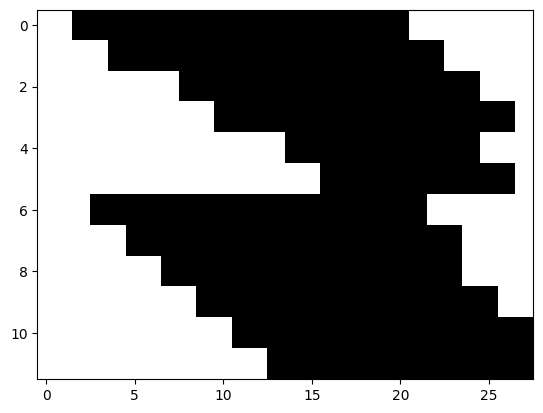

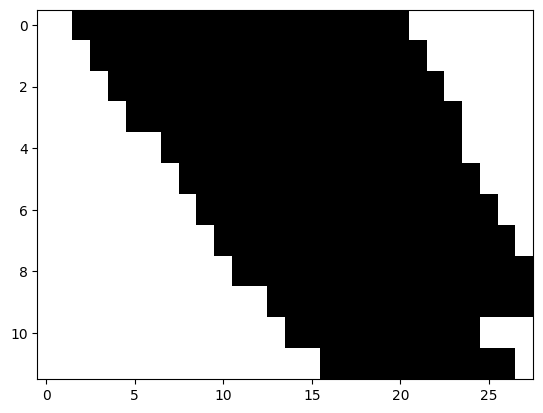

In [45]:
from matrex import msro

strings = constraints_sites[0] + constraints_sites[1]

mpo_location_matrix = np.zeros((len(strings), num_sites))
for row_idx, sublist in enumerate(strings):
    for subsublist in sublist:
        for index in subsublist:
            mpo_location_matrix[row_idx][index] = 1

optimised_order = msro(mpo_location_matrix)
strings = [strings[index] for index in optimised_order]

plt.imshow(mpo_location_matrix, cmap="Greys", aspect="auto")  # Naive
plt.show()

mpo_location_matrix = np.zeros((len(strings), num_sites))
for row_idx, sublist in enumerate(strings):
    for subsublist in sublist:
        for index in subsublist:
            mpo_location_matrix[row_idx][index] = 1

plt.imshow(mpo_location_matrix, cmap="Greys", aspect="auto")  # Optimised
plt.show()

Now the fun part, MPS-MPO contraction. But first, we apply the bias channel to our error state. This is done to bias our output towards the received input. This is done by distributing the amplitude around the initial basis product state to other basis product states in the descending order by Hamming distance.

In [46]:
renormalise = True
result_to_explicit = False
sites_to_bias = list(range(num_logicals, num_sites))
error_mps = apply_bitflip_bias(
    mps=error_mps,
    sites_to_bias=sites_to_bias,
    renormalise=renormalise,
)

In [47]:
entropies, bond_dims = [], []

In [48]:
error_mps, entrps, bnd_dims = apply_constraints(
    error_mps,
    constraints_sites[0],
    constraints_tensors,
    renormalise=renormalise,
    result_to_explicit=result_to_explicit,
    strategy="Optimised",
    return_entropies_and_bond_dims=True,
)
entropies += entrps
bond_dims += bnd_dims
error_mps, entrps, bnd_dims = apply_constraints(
    error_mps,
    constraints_sites[1],
    constraints_tensors,
    renormalise=renormalise,
    result_to_explicit=result_to_explicit,
    strategy="Optimised",
    return_entropies_and_bond_dims=True,
)
entropies += entrps
bond_dims += bnd_dims
error_mps, entrps, bnd_dims = apply_constraints(
    error_mps,
    logicals_sites,
    logicals_tensors,
    renormalise=renormalise,
    result_to_explicit=result_to_explicit,
    strategy="Optimised",
    return_entropies_and_bond_dims=True,
)
entropies += entrps
bond_dims += bnd_dims

100%|██████████| 2/2 [02:13<00:00, 66.92s/it]


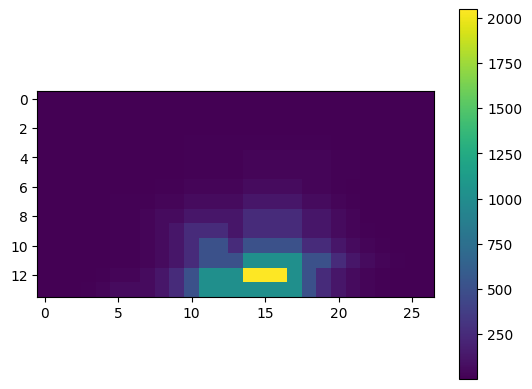

In [49]:
plt.imshow(bond_dims)
plt.colorbar()
plt.show()

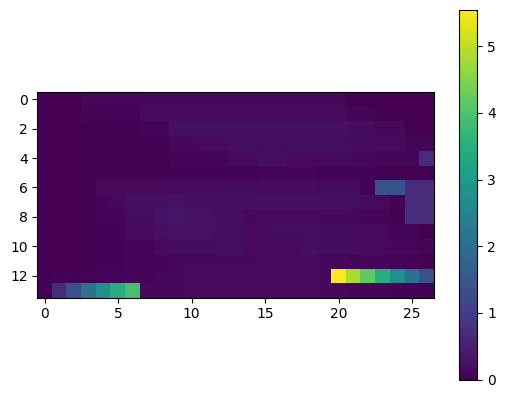

In [50]:
plt.imshow(entropies)
plt.colorbar()
plt.show()

Now, we marginalise over the message bits to get the probability distribution over the four possibilities of a logical operator: $I$, $X$, $Z$, $Y$.

In [ ]:
sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
logical = marginalise(mps=error_mps, sites_to_marginalise=sites_to_marginalise).dense(
    flatten=True, renormalise=True, norm=1
)
print(logical)

In [ ]:
strategy = "Optimised"
logical_values = [[] for _ in range(4)]
bond_dims = [4096, 2048, 1024] + list(range(512, 2, -8))

for max_bond_dim in tqdm(bond_dims):
    error_state = "0" * (num_sites - num_logicals)
    logicals_state = "+" * num_logicals
    state_string = logicals_state + error_state
    error_mps = create_custom_product_state(string=state_string)

    error_mps = apply_bitflip_bias(
        mps=error_mps,
        sites_to_bias=sites_to_bias,
        renormalise=renormalise,
    )

    error_mps = apply_constraints(
        error_mps,
        constraints_sites[0],
        constraints_tensors,
        renormalise=renormalise,
        result_to_explicit=result_to_explicit,
        strategy=strategy,
        chi_max=max_bond_dim,
        silent=True,
    )
    error_mps = apply_constraints(
        error_mps,
        constraints_sites[1],
        constraints_tensors,
        renormalise=renormalise,
        result_to_explicit=result_to_explicit,
        strategy=strategy,
        chi_max=max_bond_dim,
        silent=True,
    )
    error_mps = apply_constraints(
        error_mps,
        logicals_sites,
        logicals_tensors,
        renormalise=renormalise,
        result_to_explicit=result_to_explicit,
        strategy=strategy,
        chi_max=max_bond_dim,
        silent=True,
    )

    sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
    logical = marginalise(
        mps=error_mps, sites_to_marginalise=sites_to_marginalise
    ).dense(flatten=True, renormalise=True, norm=1)

    for i in range(4):
        logical_values[i].append(logical[i])

In [ ]:
plt.figure()
plt.plot(bond_dims, logical_values[0], marker="o", label=f"Pr(I)")
plt.plot(bond_dims, logical_values[1], marker="o", label=f"Pr(X)")
plt.plot(bond_dims, logical_values[2], marker="o", label=f"Pr(Z)")
plt.plot(bond_dims, logical_values[3], marker="o", label=f"Pr(Y)")
plt.xlabel("Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

Which indeed tells us that most likely we do not need to apply any operator!

Let's now put all of this into a function. We'll need this to run the decoder over a bunch of single- and multiqubit errors.

Let's now generate all possible one-, two- and three-qubit errors using `qecsim`.

In [ ]:
one_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=1, max_weight=1)
two_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=2, max_weight=2)
three_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=3, max_weight=3)

In [ ]:
one_qubit_errors = [pauli_to_mps(pauli) for pauli in one_qubit_paulis]
one_qubit_outputs = [
    decode_css(code, error, bias_type="Bitflip", renormalise=renormalise, silent=True)
    for error in tqdm(one_qubit_errors)
]
one_qubit_corrections_distribution = [output[0] for output in one_qubit_outputs]

In [ ]:
two_qubit_errors = [pauli_to_mps(pauli) for pauli in two_qubit_paulis]
two_qubit_outputs = [
    decode_css(code, error, bias_type="Bitflip", renormalise=renormalise, silent=True)
    for error in tqdm(two_qubit_errors)
]
two_qubit_corrections_distribution = [output[0] for output in two_qubit_outputs]

In [ ]:
three_qubit_errors = [pauli_to_mps(pauli) for pauli in three_qubit_paulis]
three_qubit_outputs = [
    decode_css(code, error, bias_type="Bitflip", renormalise=renormalise, silent=True)
    for error in tqdm(three_qubit_errors)
]
three_qubit_corrections_distribution = [output[0] for output in three_qubit_outputs]

In [ ]:
def map_distribution_to_pauli(distribution):
    mapping = {0: "I", 1: "X", 2: "Z", 3: "Y"}
    result = []

    for array in distribution:
        max_index = np.argmax(array)
        result.append(mapping[max_index])

    return result

In [ ]:
plt.hist(map_distribution_to_pauli(one_qubit_corrections_distribution))
plt.show()

In [ ]:
plt.hist(map_distribution_to_pauli(two_qubit_corrections_distribution))
plt.show()

In [ ]:
plt.hist(map_distribution_to_pauli(three_qubit_corrections_distribution))
plt.show()

Let's now check by hand that some of the decoder's nontrivial outputs are indeed correct. First of all, from all one-qubit errors we get an Identity operator which corresponds to the fact that Shor's code corrects all one-qubit errors. However, Shor's code can also correct some two-qubit errors.

In [ ]:
one_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=1, max_weight=1))
two_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=2, max_weight=2))
three_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=3, max_weight=3))

Let's take a look at the first 20 errors which result in the Identity logical operator as the output.

In [ ]:
limit = 20
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "I":
        print(two_qubit_paulis[i])
    if i > limit:
        break

We now want to dive a bit more into what is happening inside the decoder to be able to better understand the results, even though the current setup is already sufficient for calculating thresholds. For example, the first error $(X_0 X_1)$ from the list above would trigger the first $X$ parity check in the case of measuring it. This can be seen from the actual tensor network we are building (see the image below). However, in the current setup the stabilisers are being set to $0$, which is the result of the fact that the $\text{XOR}$ tensors we use project out the inputs of odd (i.e., equal to $1$) parity. What happens next after applying the logical-operator MPOs and marginalising basically spits out a marginal distribution over codewords corresponding to different parities of the logical operators.

<img src="shor-decoder.png" alt="Tensor-network error-based decoder for the Shor's 9-qubit code."/>

Let's now take a look at the errors which result in the $X$ logical operator as the output.

In [ ]:
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "X":
        print(two_qubit_paulis[i])

Similarly to the previous case, the first error $(Z_0 Z_1)$ from the list above would trigger the first $Z$ parity check which in its turn would trigger the $\text{XOR}$ tensor corresponding to the $X$ logical-operator MPO therefore the $X$ logical as the most likely output.